# Import

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 레포 정보 담긴 JSON 파일 업로드
- index: 순서
- category: reference / archived / official / community
- repo_name: 레포 (MCP 서버) 이름
- number_of_tools: tool 개수
- number_of_names: name 개수
- number_of_descriptions: description 개수

In [3]:
file = "repo_name_des_merged.json"

with open(file, "r", encoding="utf-8") as f:
    data = json.load(f)

# Tool 단위 통계

## 전체 Tool

In [6]:
total_tools = sum(entry["number_of_tools"] for entry in data)
total_names = sum(entry["number_of_names"] for entry in data)
total_descriptions = sum(entry["number_of_descriptions"] for entry in data)

print(f"전체 레포 수: {len(data)}")
print(f"전체 tool 개수 합계: {total_tools:,}")
print(f"전체 name 개수 합계: {total_names:,}")
print(f"전체 description 개수 합계: {total_descriptions:,}")

# 전체 tool 대비 name / description 존재율(커버리지) 계산
name_coverage_rate = total_names / total_tools * 100
description_coverage_rate = total_descriptions / total_tools * 100

print(f"\nName Coverage : {name_coverage_rate:.2f}%")
print(f"Description Coverage : {description_coverage_rate:.2f}%")


전체 레포 수: 50
전체 tool 개수 합계: 843
전체 name 개수 합계: 760
전체 description 개수 합계: 703

Name Coverage : 90.15%
Description Coverage : 83.39%


## 카테고리별 통계

In [7]:
df = pd.DataFrame(data)

# 카테고리별 통계 집계
grouped = df.groupby("category").agg(
    total_tools=("number_of_tools", "sum"),
    total_names=("number_of_names", "sum"),
    total_descriptions=("number_of_descriptions", "sum")
).reset_index()

# 커버리지 계산
grouped["name_coverage(%)"] = (grouped["total_names"] / grouped["total_tools"] * 100).round(2)
grouped["description_coverage(%)"] = (grouped["total_descriptions"] / grouped["total_tools"] * 100).round(2)

# 출력 순서 지정
order = ["reference", "archived", "official", "community"]
grouped = grouped.set_index("category").loc[order].reset_index()

grouped


,category,total_tools,total_names,total_descriptions,name_coverage(%),description_coverage(%)
0,reference,52,52,52,100.00,100.00
1,archived,78,78,78,100.00,100.00
2,official,442,434,377,98.19,85.29
3,community,271,196,196,72.32,72.32


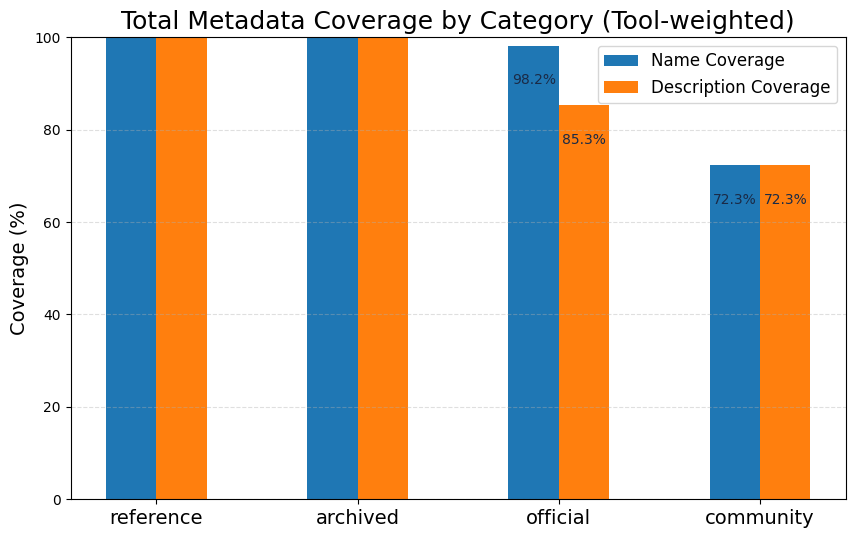

In [9]:
x = np.arange(len(grouped))
width = 0.25

plt.figure(figsize=(10, 6))

bars_name = plt.bar(x - width/2, grouped["name_coverage(%)"], width, label="Name Coverage")
bars_desc = plt.bar(x + width/2, grouped["description_coverage(%)"], width, label="Description Coverage")

plt.xticks(x, grouped["category"], fontsize=14)
plt.ylabel("Coverage (%)", fontsize=14)
plt.title("Total Metadata Coverage by Category (Tool-weighted)", fontsize=18)
plt.ylim(0, 100)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.4)

# 결손값이 있는 official, community 값만 그래프에 표시
targets = ["official", "community"]

for cat in targets:
    idx = grouped.index[grouped["category"] == cat].tolist()[0]

    # name coverage 막대
    bar_name = bars_name[idx]
    value_name = grouped.loc[idx, "name_coverage(%)"]
    plt.text(
        bar_name.get_x() + bar_name.get_width()/2,
        bar_name.get_height() - 6,
        f"{value_name:.1f}%", ha="center", va="top",
        fontsize=10, color="#1a2a46"
    )

    # description coverage 막대
    bar_desc = bars_desc[idx]
    value_desc = grouped.loc[idx, "description_coverage(%)"]
    plt.text(
        bar_desc.get_x() + bar_desc.get_width()/2,
        bar_desc.get_height() - 6,
        f"{value_desc:.1f}%", ha="center", va="top",
        fontsize=10, color="#1a2a46"
    )


plt.show()


## 레포별 통계

In [14]:
total_repos = len(data)

# name 커버리지: name 개수가 tool과 동일한 레포 수 / 전체 레포 수
full_name_repos = sum(
    1 for entry in data if entry["number_of_names"] == entry["number_of_tools"]
)

# description 커버리지: description 개수가 tool과 동일한 레포 수 / 전체 레포 수
full_description_repos = sum(
    1 for entry in data if entry["number_of_descriptions"] == entry["number_of_tools"]
)

name_coverage = full_name_repos / total_repos * 100
description_coverage = full_description_repos / total_repos * 100

print("필드별 레포 커버리지 (100% 제공 기준)")
print(f"전체 레포 수: {total_repos}")
print(f"name 커버리지: {full_name_repos} / {total_repos}  ({name_coverage:.2f}%)")
print(f"description 커버리지: {full_description_repos} / {total_repos}  ({description_coverage:.2f}%)")

필드별 레포 커버리지 (100% 제공 기준)
전체 레포 수: 50
name 커버리지: 46 / 50  (92.00%)
description 커버리지: 44 / 50  (88.00%)


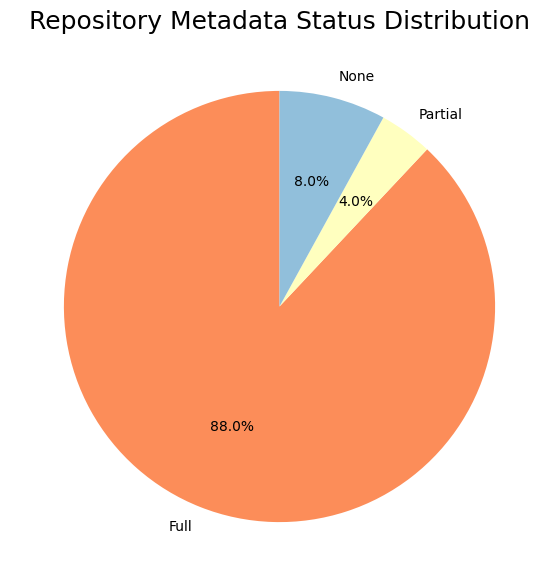

In [15]:
full = 0  # name + description 둘 다 100%
partial = 0  # 둘 중 일부만 부족
none = 0  # name & description 모두 0%

for entry in data:
    names_full = entry["number_of_names"] == entry["number_of_tools"]
    desc_full = entry["number_of_descriptions"] == entry["number_of_tools"]

    if names_full and desc_full:
        full += 1
    elif entry["number_of_names"] == 0 and entry["number_of_descriptions"] == 0:
        none += 1
    else:
        partial += 1

labels = ["Full", "Partial", "None"]
counts = [full, partial, none]
colors = ["#fc8d59", "#ffffbf", "#91bfdb"]

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=labels, autopct="%.1f%%", startangle=90, colors=colors)
plt.title("Repository Metadata Status Distribution", fontsize=18)
plt.show()


# 레포 단위 통계

## 카테고리별 통계

In [16]:
df = pd.DataFrame(data)

categories = ["reference", "archived", "official", "community"]

rows = []

for category in categories:
    sub = df[df["category"] == category]
    total_repos = len(sub)
    full_name_repos = sum(sub["number_of_names"] == sub["number_of_tools"])
    full_desc_repos = sum(sub["number_of_descriptions"] == sub["number_of_tools"])

    name_coverage = (full_name_repos / total_repos * 100) if total_repos > 0 else 0
    desc_coverage = (full_desc_repos / total_repos * 100) if total_repos > 0 else 0

    rows.append({
        "category": category,
        "total_repos": total_repos,
        "full_name_repos": full_name_repos,
        "full_description_repos": full_desc_repos,
        "name_coverage(%)": round(name_coverage, 2),
        "description_coverage(%)": round(desc_coverage, 2),
    })

pd.DataFrame(rows)


,category,total_repos,full_name_repos,full_description_repos,name_coverage(%),description_coverage(%)
0,reference,7,7,7,100.00,100.0
1,archived,13,13,13,100.00,100.0
2,official,15,14,12,93.33,80.0
3,community,15,12,12,80.00,80.0


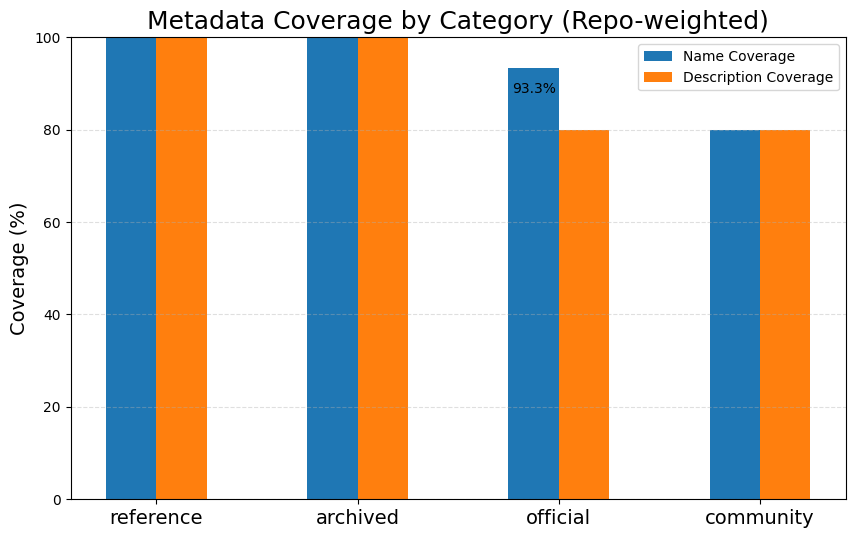

In [19]:
df = pd.DataFrame(data)

categories = ["reference", "archived", "official", "community"]

rows = []
for category in categories:
    sub = df[df["category"] == category]
    total_repos = len(sub)
    full_name_repos = sum(sub["number_of_names"] == sub["number_of_tools"])
    full_desc_repos = sum(sub["number_of_descriptions"] == sub["number_of_tools"])
    name_coverage = full_name_repos / total_repos * 100
    desc_coverage = full_desc_repos / total_repos * 100
    rows.append([category, name_coverage, desc_coverage])

coverage_df = pd.DataFrame(rows, columns=["category", "name_coverage", "description_coverage"])

x = np.arange(len(coverage_df))
width = 0.25

plt.figure(figsize=(10, 6))
bars_name = plt.bar(x - width/2, coverage_df["name_coverage"], width, label="Name Coverage")
bars_desc = plt.bar(x + width/2, coverage_df["description_coverage"], width, label="Description Coverage")

plt.xticks(x, coverage_df["category"], fontsize=14)
plt.ylabel("Coverage (%)", fontsize=14)
plt.title("Metadata Coverage by Category (Repo-weighted)", fontsize=18)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

official_index = coverage_df.index[coverage_df["category"] == "official"].tolist()[0]
official_bar = bars_name[official_index]
value = coverage_df.loc[official_index, "name_coverage"]
plt.text(
    official_bar.get_x() + official_bar.get_width()/2,
    official_bar.get_height() -6,
    f"{value:.1f}%",
    ha='center', va='bottom', fontsize=10, color='black'
)

plt.show()


## 메타데이터 누락 레포 정보

In [20]:
missing_name_repos = [
    (entry["repo_name"], entry["category"])
    for entry in data
    if entry["number_of_names"] < entry["number_of_tools"]
]

missing_description_repos = [
    (entry["repo_name"], entry["category"])
    for entry in data
    if entry["number_of_descriptions"] < entry["number_of_tools"]
]

print("Name 누락 레포")
print(f"개수: {len(missing_name_repos)}")
for repo, category in missing_name_repos:
    print(f"{repo}  ({category})")

print("\nDescription 누락 레포")
print(f"개수: {len(missing_description_repos)}")
for repo, category in missing_description_repos:
    print(f"{repo}  ({category})")

Name 누락 레포
개수: 4
Semgrep  (official)
Blender  (community)
WhatsApp MCP  (community)
Atlassian  (community)

Description 누락 레포
개수: 6
Semgrep  (official)
MCP Toolbox for Databases (Google)  (official)
Pipedream  (official)
Blender  (community)
WhatsApp MCP  (community)
Atlassian  (community)


In [22]:
# Description 누락 레포가 Name 누락 레포를 포함하기 때문에
# Description 누락 레포 6개 정보 표시

rows = []

for repo, category in missing_description_repos:
    for entry in data:
        if entry["repo_name"] == repo:
            total = entry["number_of_tools"]
            names = entry["number_of_names"]
            descriptions = entry["number_of_descriptions"]
            missing_name_rate = (total - names) / total * 100 if total > 0 else 0
            missing_description_rate = (total - descriptions) / total * 100 if total > 0 else 0

            rows.append({
                "repo_name": repo,
                "category": category,
                "total_tools": total,
                "missing_name_rate(%)": round(missing_name_rate, 2),
                "missing_description_rate(%)": round(missing_description_rate, 2)
            })
            break

df = pd.DataFrame(rows)
df


,repo_name,category,total_tools,missing_name_rate(%),missing_description_rate(%)
0,Semgrep,official,8,100.0,100.00
1,MCP Toolbox for Databases (Google),official,167,0.0,32.34
2,Pipedream,official,9,0.0,33.33
3,Blender,community,22,100.0,100.00
4,WhatsApp MCP,community,12,100.0,100.00
5,Atlassian,community,41,100.0,100.00
